
**ACGAN code practice**
 * paper link : https://arxiv.org/pdf/1610.09585.pdf


In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.utils import save_image

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Hyper-parameters
batch_size = 100
latent_dim = 100
num_classes = 10
learning_rate = 0.0003
num_epochs = 100

In [8]:
train_dataset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True,
                                             transform = transforms.Compose([transforms.ToTensor(),
                                                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))
dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size  = batch_size ,
                                         shuffle = True, num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


학습용 이미지 몇 개를 살펴보자.

In [9]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


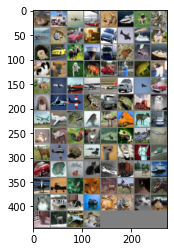

 frog truck plane  ship  frog  ship   dog  bird  ship  frog   car   dog   car plane  ship   dog   dog   car  deer  ship truck  frog  frog  ship   dog  deer   dog  frog truck  bird  frog   dog  deer plane  ship plane plane   car plane   car   dog   car plane  frog truck  frog truck   dog plane plane  frog  bird  bird truck  deer   car   cat  deer  bird   cat  deer  frog plane plane horse plane  frog plane  bird  ship   cat truck   car  frog plane   cat  ship truck  deer  ship plane plane  deer   cat  deer horse   cat horse   cat  ship   dog  ship  deer  frog   cat   dog   cat  deer plane   cat


In [10]:
# 이미지를 보여주기 위한 함수
def imshow(img):
  img = img / 2 + .5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# 학습용 이미지를 무작위로 가져오기.
dataiter = iter(dataloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 레이블 출력하기
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

모델 정의

In [11]:
def make_one_hot(idx_list, num_classes = 10):
  one_hot = torch.zeros(idx_list.size(0), num_classes)
  for i, idx in enumerate(idx_list):
    one_hot[i][idx] = 1
  return one_hot

In [12]:
class Generator(nn.Module):
  def __init__(self, num_classes = 10):
    super(Generator, self).__init__()

    def Block(in_channels, out_channels, stride = 2,padding = 1,  normalize  = True, relu = True):
      module_list = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = stride,padding = padding, bias = False)]
      if normalize :
        module_list.append(nn.BatchNorm2d(out_channels))
      if relu:
        module_list.append(nn.ReLU(inplace = True))

      return module_list
    self.fc = nn.Linear(latent_dim + num_classes, 384)
    self.relu = nn.ReLU(inplace = True)

    self.upsample_model = nn.Sequential(
        *Block(384, 192, 1, 0) ,    # (batch_size, 192, 4, 4)
        *Block(192, 96), # (batch_size, 96, 8, 8)
        *Block(96, 48), # (batch_size, 48, 16, 16)
        *Block(48, 3, normalize = False, relu = False), # (batch_size, 3, 32, 32)
        nn.Tanh()

    )

  def forward(self, z, c):
    '''
    z : latent vector, shape of (batch_size, latent_dim)
    c = class labels,  shape of (batch_size, num_classes)
    '''
    conditioned_z = torch.cat([z, c], dim = -1)     # (batch_size, latent_dim + num_classes)
    out = self.relu(self.fc(conditioned_z))
    out = out.unsqueeze(2).unsqueeze(3)     # for input form of transposed Conv layer

    generated_imgs = self.upsample_model(out)
    return generated_imgs


In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def Block(in_channels, out_channels, stride, normalize = True):
      module_list = [nn.Conv2d(in_channels, out_channels,kernel_size= 3, stride = stride, padding = 1, bias = False),
                     nn.Dropout(0.5),]
      if normalize : 
        module_list.append(nn.BatchNorm2d(out_channels))
      module_list.append(nn.LeakyReLU(0.2, inplace = True))
      return module_list


    self.model = nn.Sequential(
        *Block(3, 16, 2, normalize = False),   # (batch_size, 16, 16, 16)
        *Block(16, 32, 1),
        *Block(32, 64, 2),   # (batch_size, 64, 8, 8)
        *Block(64, 128, 1),
        *Block(128, 256, 2),   # (batch_size, 256, 4, 4)
        *Block(256, 512, 2),   # (batch_size, 512, 2, 2)
    )
    self.fc = nn.Linear(2048, 11)

  def forward(self, imgs):
    # imgs, shape of (batch_size, 3, 32, 32)
    # class labels, shape of (batch_size, num_classes)
    batch_size = imgs.size(0)
    
    output = self.model(imgs)
    output = output.view(batch_size, -1)    # (batch_size, 2048)
    output = self.fc(output)    # (batch_size, 11)
    
    class_prob = output[:, :10]    # P(C = c | X)
    real_prob = torch.sigmoid(output[:, -1]).unsqueeze(-1)      # P(S = real | X)
    return real_prob, class_prob


In [14]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [15]:
# Define Losses
adversarial_loss = nn.BCELoss()
class_loss = nn.CrossEntropyLoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

In [17]:
sample_interval = 2500
for epoch in range(num_epochs):
  for i, (imgs, labels) in enumerate(dataloader):
    imgs = imgs.to(device)
    labels = make_one_hot(labels).to(device)
    random_labels = make_one_hot(torch.LongTensor(np.random.randint(0, num_classes, imgs.size(0)))).to(device)

    z = torch.normal(mean = 0, std = 1, size = (imgs.size(0), latent_dim)).to(device)
    fake_imgs = generator(z, random_labels)

    # Generate labels for real and fake
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    # Train the Generator
    optimizer_G.zero_grad()
    
    loss_G = (adversarial_loss(discriminator(fake_imgs)[0], real) + class_loss(discriminator(fake_imgs)[1], random_labels)) / 2
    loss_G.backward()
    optimizer_G.step()

    # Train the Discriminator
    optimizer_D.zero_grad()
    loss_D = (adversarial_loss(discriminator(imgs)[0], real) + adversarial_loss(discriminator(fake_imgs.detach())[0], fake) + class_loss(discriminator(imgs)[1], labels) + class_loss(discriminator(fake_imgs.detach())[1], random_labels)) / 4
    loss_D.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if i % sample_interval == 0:
      save_image(fake_imgs[:25], f"{done}.png", nrow = 5, normalize = True)

  print(f"Epoch[{epoch + 1} / {num_epochs}], Generator Loss : {loss_G.item()}, Discriminator Loss : {loss_D.item()}")
# Save the model
torch.save(generator.state_dict(), "ACGAN_gen.ckpt")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[1 / 100], Generator Loss : 1.9698498249053955, Discriminator Loss : 1.2168307304382324
Epoch[2 / 100], Generator Loss : 1.338678240776062, Discriminator Loss : 1.2237224578857422
Epoch[3 / 100], Generator Loss : 0.8976569175720215, Discriminator Loss : 0.9767420887947083
Epoch[4 / 100], Generator Loss : 0.8617124557495117, Discriminator Loss : 0.850892961025238
Epoch[5 / 100], Generator Loss : 0.8934895992279053, Discriminator Loss : 0.7599397897720337
Epoch[6 / 100], Generator Loss : 0.803652286529541, Discriminator Loss : 0.7358526587486267
Epoch[7 / 100], Generator Loss : 0.9738548398017883, Discriminator Loss : 0.761180579662323
Epoch[8 / 100], Generator Loss : 1.0499796867370605, Discriminator Loss : 0.76694256067276
Epoch[9 / 100], Generator Loss : 0.8967993259429932, Discriminator Loss : 0.7775945663452148
Epoch[10 / 100], Generator Loss : 0.8019670248031616, Discriminator Loss : 0.6826676726341248
Epoch[11 / 100], Generator Loss : 0.40414440631866455, Discriminator Loss :

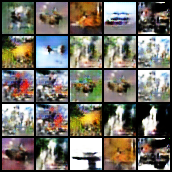

In [18]:
from IPython.display import Image
Image("43500.png")

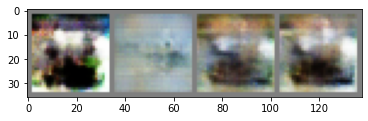

Class : plane


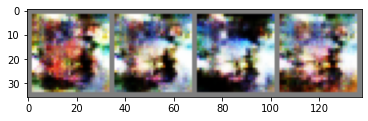

Class : car


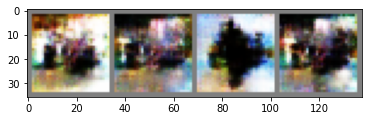

Class : bird


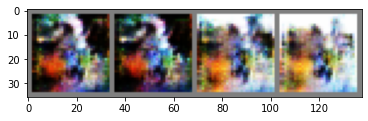

Class : cat


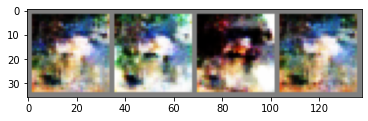

Class : deer


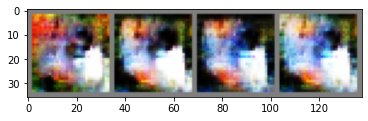

Class : dog


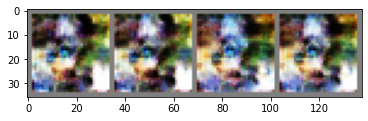

Class : frog


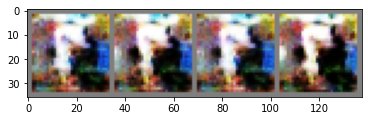

Class : horse


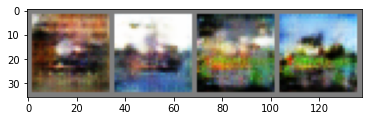

Class : ship


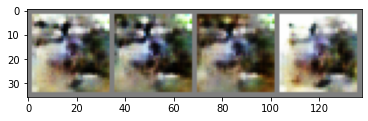

Class : truck


In [19]:
# 각 클래스별로 생성된 이미지 4개씩 출력하기
for i in range(num_classes):
  z = torch.normal(mean = 0, std = 1, size = (4, latent_dim)).to(device)
  labels = torch.zeros(4, num_classes).to(device)
  labels[:, i] = 1

  generated_imgs = generator(z, labels)
  
  # 이미지 출력하기
  imshow(torchvision.utils.make_grid(generated_imgs.cpu()))
  # 클래스 출력하기
  print(f"Class : {classes[i]}")